# 使用cuBLAS库进行线性代数运算，计算多种指标

在本部分，我们将使用cuBLAS库进行简单的线性代数运算，计算不同的指标，包括NDVI、SAVI、VARI、MNDWI和NDMI等。

In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda import gpuarray
import numpy as np
import matplotlib.pyplot as plt
import time
import tifffile as tiff
from skcuda.cublas import cublasCreate, cublasDestroy, cublasSaxpy, cublasSgemv

## 1、计算NDVI

In [8]:
# 读取图像数据
def load_image(image_path):
    img = tiff.imread(image_path)[:,:,0]
    return img.astype(np.float32)


def visualize_image(image, height=954, width=298):
    # 将图像数据重塑为二维数组
    image_reshaped = image.reshape((height, width))
    
    # 图像在 [-1, 1] 范围内（归一化显示）
    image_normalized = np.clip(image_reshaped, -1, 1)
    image_normalized = ((image_normalized + 1) / 2 * 255).astype(np.uint8)
    
    # 使用 Matplotlib 显示图像
    plt.figure(figsize=(10, 8))
    plt.imshow(image_normalized, cmap='gray')
    plt.axis('off')  # 去掉坐标轴
    plt.show()

def compute_NDVI_with_cuBLAS(nir_image, red_image, epsilon=1e-6):
    start_time = time.time()

    # 展平图像
    nir_image_flat = nir_image.flatten()
    red_image_flat = red_image.flatten()

    # 初始化cuBLAS
    handle = cublasCreate()

    # 将NIR和RED图像数据转移到GPU
    nir_gpu = gpuarray.to_gpu(nir_image_flat.astype(np.float32))
    red_gpu = gpuarray.to_gpu(red_image_flat.astype(np.float32))

    # 计算NIR - RED
    axpy_result = gpuarray.empty_like(nir_gpu)
    cublasSaxpy(handle, nir_gpu.size, np.float32(1), nir_gpu.gpudata, 1, axpy_result.gpudata, 1)
    cublasSaxpy(handle, nir_gpu.size, np.float32(-1), red_gpu.gpudata, 1, axpy_result.gpudata, 1)

    # 计算NIR + RED
    axpy_sum = gpuarray.empty_like(nir_gpu)
    cublasSaxpy(handle, nir_gpu.size, np.float32(1), nir_gpu.gpudata, 1, axpy_sum.gpudata, 1)
    cublasSaxpy(handle, nir_gpu.size, np.float32(1), red_gpu.gpudata, 1, axpy_sum.gpudata, 1)
    
    # 对于分母为零的部分，将其设置为一个小常数 epsilon
    axpy_sum = axpy_sum + (axpy_sum == 0) * epsilon  # 当分母为零时加上一个小常数 epsilon

    # 计算NDVI = (NIR - RED) / (NIR + RED)，避免除以零
    ndvi_gpu = gpuarray.empty_like(nir_gpu)
    
    # 使用GPU上的除法操作
    ndvi_gpu = axpy_result / axpy_sum

    # 将计算结果从GPU复制回CPU
    ndvi_image = ndvi_gpu.get()

    # 释放cuBLAS资源
    cublasDestroy(handle)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"NDVI计算完成。GPU计算时间：{elapsed_time:.4f}秒。")

    return ndvi_image

In [10]:
nir_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff")
red_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff")

ndvi_image = compute_NDVI_with_cuBLAS(nir_image, red_image, epsilon=1e-6)

NDVI计算完成。GPU计算时间：0.0134秒。


展示图像

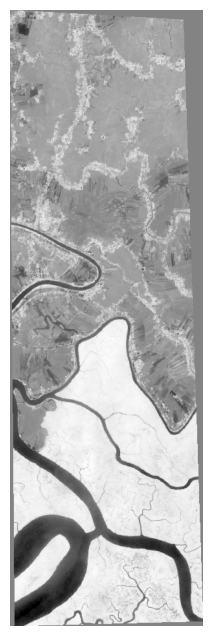

In [52]:
visualize_image(ndvi_image, height=954, width=298)

## 2、计算SAVI

In [11]:
def compute_SAVI_with_cuBLAS(nir_image, red_image):
    start_time = time.time()

    # 展平图像
    nir_image_flat = nir_image.flatten()
    red_image_flat = red_image.flatten()

    # 初始化cuBLAS
    handle = cublasCreate()

    # 将NIR和RED图像数据转移到GPU
    nir_gpu = gpuarray.to_gpu(nir_image_flat.astype(np.float32))
    red_gpu = gpuarray.to_gpu(red_image_flat.astype(np.float32))

    # 计算NIR - RED
    axpy_result = gpuarray.empty_like(nir_gpu)
    cublasSaxpy(handle, nir_gpu.size, np.float32(1), nir_gpu.gpudata, 1, axpy_result.gpudata, 1)
    cublasSaxpy(handle, nir_gpu.size, np.float32(-1), red_gpu.gpudata, 1, axpy_result.gpudata, 1)

    # 计算NIR + RED + 0.5
    axpy_sum = gpuarray.empty_like(nir_gpu)
    cublasSaxpy(handle, nir_gpu.size, np.float32(1), nir_gpu.gpudata, 1, axpy_sum.gpudata, 1)
    cublasSaxpy(handle, nir_gpu.size, np.float32(1), red_gpu.gpudata, 1, axpy_sum.gpudata, 1)

    # 添加0.5到分母
    axpy_sum = axpy_sum + 0.5

    # 计算SAVI = ((NIR - RED) / (NIR + RED + 0.5)) * 1.5
    savi_gpu = axpy_result / axpy_sum  # 计算(SAVI)
    savi_gpu *= 1.5  # 乘以1.5

    # 将计算结果从GPU复制回CPU
    savi_image = savi_gpu.get()

    # 释放cuBLAS资源
    cublasDestroy(handle)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"SAVI计算完成。GPU计算时间：{elapsed_time:.4f}秒。")

    return savi_image

In [12]:
nir_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff")
red_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff")

savi_image = compute_SAVI_with_cuBLAS(nir_image, red_image)

SAVI计算完成。GPU计算时间：0.0090秒。


展示图像

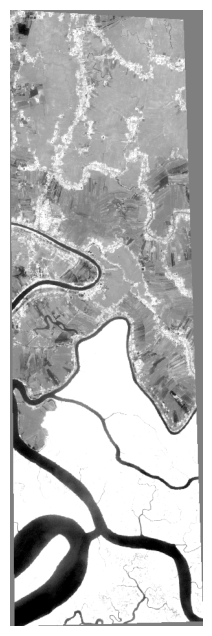

In [57]:
visualize_image(savi_image, height=954, width=298)

## 3、计算VARI

In [13]:
def compute_VARI_with_cuBLAS(green_image, red_image, blue_image, epsilon=1e-6):
    start_time = time.time()

    # 展平图像
    green_image_flat = green_image.flatten()
    red_image_flat = red_image.flatten()
    blue_image_flat = blue_image.flatten()

    # 初始化cuBLAS
    handle = cublasCreate()

    # 将图像数据转移到GPU
    green_gpu = gpuarray.to_gpu(green_image_flat.astype(np.float32))
    red_gpu = gpuarray.to_gpu(red_image_flat.astype(np.float32))
    blue_gpu = gpuarray.to_gpu(blue_image_flat.astype(np.float32))

    # 计算 GREEN - RED
    axpy_result = gpuarray.empty_like(green_gpu)
    cublasSaxpy(handle, green_gpu.size, np.float32(1), green_gpu.gpudata, 1, axpy_result.gpudata, 1)
    cublasSaxpy(handle, green_gpu.size, np.float32(-1), red_gpu.gpudata, 1, axpy_result.gpudata, 1)

    # 计算 GREEN + RED - BLUE
    axpy_sum = gpuarray.empty_like(green_gpu)
    cublasSaxpy(handle, green_gpu.size, np.float32(1), green_gpu.gpudata, 1, axpy_sum.gpudata, 1)
    cublasSaxpy(handle, green_gpu.size, np.float32(1), red_gpu.gpudata, 1, axpy_sum.gpudata, 1)
    cublasSaxpy(handle, green_gpu.size, np.float32(-1), blue_gpu.gpudata, 1, axpy_sum.gpudata, 1)

    # 对于分母为零的部分，将其设置为一个小常数 epsilon
    axpy_sum = axpy_sum + (axpy_sum == 0) * epsilon  # 当分母为零时加上一个小常数 epsilon

    # 计算 VARI = (GREEN - RED) / (GREEN + RED - BLUE)
    vari_gpu = axpy_result / axpy_sum  # 计算 VARI

    # 将计算结果从GPU复制回CPU
    vari_image = vari_gpu.get()

    # 释放cuBLAS资源
    cublasDestroy(handle)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"VARI计算完成。GPU计算时间：{elapsed_time:.4f}秒。")

    return vari_image


In [15]:
red_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff")
green_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff")
blue_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff")

vari_image = compute_VARI_with_cuBLAS(green_image, red_image, blue_image, epsilon=1e-6)

VARI计算完成。GPU计算时间：0.0177秒。


展示图像

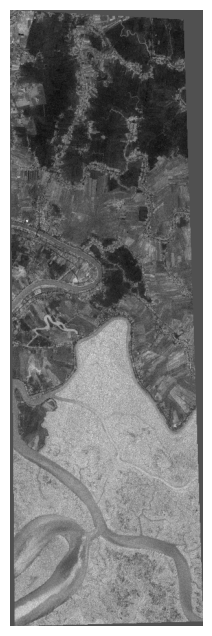

In [63]:
visualize_image(vari_image, height=954, width=298)

## 4、计算MNDWI

In [16]:
def compute_MNDWI_with_cuBLAS(green_image, swir_image, epsilon=1e-6):
    start_time = time.time()

    # 展平图像
    green_image_flat = green_image.flatten()
    swir_image_flat = swir_image.flatten()

    # 初始化cuBLAS
    handle = cublasCreate()

    # 将图像数据转移到GPU
    green_gpu = gpuarray.to_gpu(green_image_flat.astype(np.float32))
    swir_gpu = gpuarray.to_gpu(swir_image_flat.astype(np.float32))

    # 计算 GREEN - SWIR
    axpy_result = gpuarray.empty_like(green_gpu)
    cublasSaxpy(handle, green_gpu.size, np.float32(1), green_gpu.gpudata, 1, axpy_result.gpudata, 1)
    cublasSaxpy(handle, green_gpu.size, np.float32(-1), swir_gpu.gpudata, 1, axpy_result.gpudata, 1)

    # 计算 GREEN + SWIR
    axpy_sum = gpuarray.empty_like(green_gpu)
    cublasSaxpy(handle, green_gpu.size, np.float32(1), green_gpu.gpudata, 1, axpy_sum.gpudata, 1)
    cublasSaxpy(handle, green_gpu.size, np.float32(1), swir_gpu.gpudata, 1, axpy_sum.gpudata, 1)

    # 通过条件处理避免分母为零
    axpy_sum = axpy_sum + (axpy_sum == 0) * epsilon  # 当分母为零时加上一个小常数 epsilon

    # 计算 MNDWI = (GREEN - SWIR) / (GREEN + SWIR)
    mndwi_gpu = axpy_result / axpy_sum  # 计算 MNDWI

    # 将计算结果从GPU复制回CPU
    mndwi_image = mndwi_gpu.get()

    # 释放cuBLAS资源
    cublasDestroy(handle)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"MNDWI计算完成。GPU计算时间：{elapsed_time:.4f}秒。")

    return mndwi_image

In [19]:
green_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff")
swir_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff")

mndwi_image = compute_MNDWI_with_cuBLAS(green_image, swir_image, epsilon=1e-6)

MNDWI计算完成。GPU计算时间：0.0135秒。


展示图像

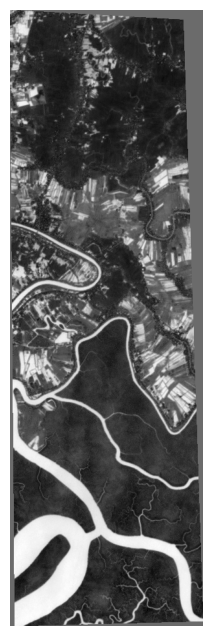

In [68]:
visualize_image(mndwi_image, heigt=954, width=298)

## 5、计算NDMI

In [20]:
def compute_NDMI_with_cuBLAS(nir_image, swir_image, epsilon=1e-6):
    start_time = time.time()

    # 展平图像
    nir_image_flat = nir_image.flatten()
    swir_image_flat = swir_image.flatten()

    # 初始化cuBLAS
    handle = cublasCreate()

    # 将图像数据转移到GPU
    nir_gpu = gpuarray.to_gpu(nir_image_flat.astype(np.float32))
    swir_gpu = gpuarray.to_gpu(swir_image_flat.astype(np.float32))

    # 计算 NIR - SWIR
    axpy_result = gpuarray.empty_like(nir_gpu)
    cublasSaxpy(handle, nir_gpu.size, np.float32(1), nir_gpu.gpudata, 1, axpy_result.gpudata, 1)
    cublasSaxpy(handle, nir_gpu.size, np.float32(-1), swir_gpu.gpudata, 1, axpy_result.gpudata, 1)

    # 计算 NIR + SWIR
    axpy_sum = gpuarray.empty_like(nir_gpu)
    cublasSaxpy(handle, nir_gpu.size, np.float32(1), nir_gpu.gpudata, 1, axpy_sum.gpudata, 1)
    cublasSaxpy(handle, nir_gpu.size, np.float32(1), swir_gpu.gpudata, 1, axpy_sum.gpudata, 1)

    # 通过条件处理避免分母为零
    axpy_sum = axpy_sum + (axpy_sum == 0) * epsilon  # 当分母为零时加上一个小常数 epsilon

    # 计算 NDMI = (NIR - SWIR) / (NIR + SWIR)
    ndmi_gpu = axpy_result / axpy_sum  # 计算 NDMI

    # 将计算结果从GPU复制回CPU
    ndmi_image = ndmi_gpu.get()

    # 释放cuBLAS资源
    cublasDestroy(handle)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"NDMI计算完成。GPU计算时间：{elapsed_time:.4f}秒。")

    return ndmi_image

In [22]:
nir_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff")
swir_image = load_image("/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff")

ndmi_image = compute_NDMI_with_cuBLAS(nir_image, swir_image, epsilon=1e-6)

NDMI计算完成。GPU计算时间：0.0130秒。


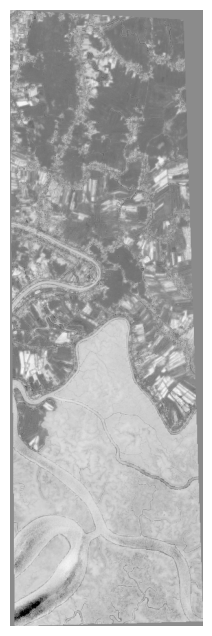

In [72]:
visualize_image(ndmi_image, height=954, width=298)